# Comparison between the OpticStudio and Optiland backends

In [1]:
from __future__ import annotations

from dataclasses import asdict
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import visisipy
from visisipy.backend import BackendSettings
from visisipy.opticstudio import OpticStudioBackend
from visisipy.optiland import OptilandBackend

if TYPE_CHECKING:
    from visisipy.analysis.cardinal_points import CardinalPointsResult
    from visisipy.analysis.refraction import FourierPowerVectorRefraction

In [2]:
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning, module="zospy")

Initialize both backends

In [3]:
BACKEND_SETTINGS = BackendSettings(
    field_type="angle",
    fields=[(0, 0)],
    wavelengths=[0.543],
    aperture_type="entrance_pupil_diameter",
    aperture_value=1.0,
)

OpticStudioBackend.initialize(**BACKEND_SETTINGS, mode="standalone", ray_aiming="off")
OptilandBackend.initialize(**BACKEND_SETTINGS)

Define an eye model. Instead of the default material model (which is a fitted model for all wavelengths), we will use the refractive indices of the Navarro model for light of 543 nm.

In [4]:
model = visisipy.EyeModel(geometry=visisipy.models.NavarroGeometry(), materials=visisipy.models.NavarroMaterials543())
model_myopic = visisipy.EyeModel(
    visisipy.models.create_geometry(axial_length=model.geometry.axial_length + 2), visisipy.models.NavarroMaterials543()
)
model_hyperopic = visisipy.EyeModel(
    visisipy.models.create_geometry(axial_length=model.geometry.axial_length - 2), visisipy.models.NavarroMaterials543()
)

## Cardinal points analysis

Calculate the cardinal point locations and the difference between the two backends.

In [5]:
def cardinal_points_to_dataframe(cardinal_points: CardinalPointsResult):
    """
    Convert cardinal points to a pandas DataFrame.
    """
    cardinal_points_dict = {
        k: (float("nan"), float("nan")) if v is NotImplemented else v for k, v in asdict(cardinal_points).items()
    }

    return pd.DataFrame.from_dict(cardinal_points_dict, orient="index", columns=["object", "image"])

In [6]:
opticstudio_cardinal_points = visisipy.analysis.cardinal_points(model=model, backend=OpticStudioBackend)
optiland_cardinal_points = visisipy.analysis.cardinal_points(model=model, backend=OptilandBackend)

cardinal_points_comparison = cardinal_points_to_dataframe(opticstudio_cardinal_points).join(
    cardinal_points_to_dataframe(optiland_cardinal_points), lsuffix="_opticstudio", rsuffix="_optiland"
)

cardinal_points_comparison["object_difference"] = (
    cardinal_points_comparison["object_optiland"] - cardinal_points_comparison["object_opticstudio"]
)
cardinal_points_comparison["image_difference"] = (
    cardinal_points_comparison["image_optiland"] - cardinal_points_comparison["image_opticstudio"]
)

cardinal_points_comparison

,object_opticstudio,image_opticstudio,object_optiland,image_optiland,object_difference,image_difference
focal_lengths,-16.467904,22.029115,-16.467899,22.029115,0.000005,3.574475e-07
focal_points,-14.885414,0.000014,-7.253626,0.000014,7.631788,-2.605261e-07
principal_points,1.582490,-22.029102,9.214274,-22.029102,7.631784,3.820264e-07
anti_principal_points,-31.353319,22.029129,-23.721525,22.029129,7.631794,9.692146e-08
nodal_points,7.143701,-16.467890,14.775490,-16.467886,7.631789,4.367338e-06
anti_nodal_points,-36.914530,16.467918,-29.282741,16.467913,7.631789,-4.888390e-06


## Raytracing analysis

Perform a number of ray traces in both backends and plot the results on top of each other.

In [7]:
RAYTRACE_FIELDS = [(0, y) for y in np.arange(0, 90, step=5).astype(float)]

raytrace_opticstudio = visisipy.analysis.raytrace(
    model=model,
    coordinates=RAYTRACE_FIELDS,
    wavelengths=[0.543],
    field_type="angle",
    pupil=(0, 0),
    backend=OpticStudioBackend,
)

raytrace_optiland = visisipy.analysis.raytrace(
    model=model,
    coordinates=RAYTRACE_FIELDS,
    wavelengths=[0.543],
    field_type="angle",
    pupil=(0, 0),
    backend=OptilandBackend,
)

# Optiland uses different coordinate conventions
raytrace_optiland["z"] -= model.geometry.cornea_thickness + model.geometry.anterior_chamber_depth

Plot the ray trace results on top of each other.

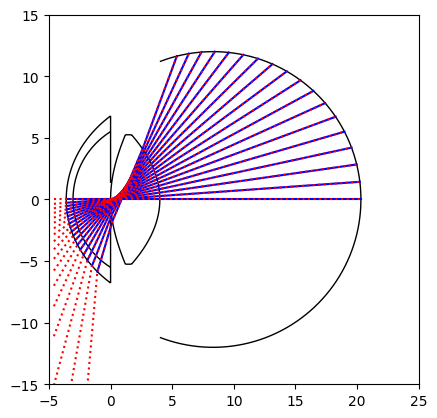

In [8]:
def plot_raytrace_result(raytrace_result: pd.DataFrame, ax: plt.Axes, color="blue", linestyle="-"):
    for _, df in raytrace_result.groupby("field"):
        ax.plot(df.z, df.y, color=color, linestyle=linestyle)


fig, ax = plt.subplots()

visisipy.plots.plot_eye(ax=ax, geometry=model.geometry, lens_edge_thickness=0.5)

plot_raytrace_result(raytrace_opticstudio, ax=ax)
plot_raytrace_result(raytrace_optiland, ax=ax, color="red", linestyle=":")

ax.set_xlim(-5, 25)
ax.set_ylim(-15, 15)
ax.set_aspect("equal")

Calculate the distances between the ray trace results point by point and plot them as a function of the Z-coordinate and the surface index.

In [9]:
_select_columns = ["field", "index", "x", "y", "z"]

raytrace_comparison = pd.merge(
    raytrace_opticstudio[_select_columns],
    raytrace_optiland[_select_columns],
    on=["field", "index"],
    suffixes=("_opticstudio", "_optiland"),
).query("index != 0")

raytrace_comparison.eval(
    "distance = sqrt((x_optiland - x_opticstudio)**2 + (y_optiland - y_opticstudio)**2)", inplace=True
)

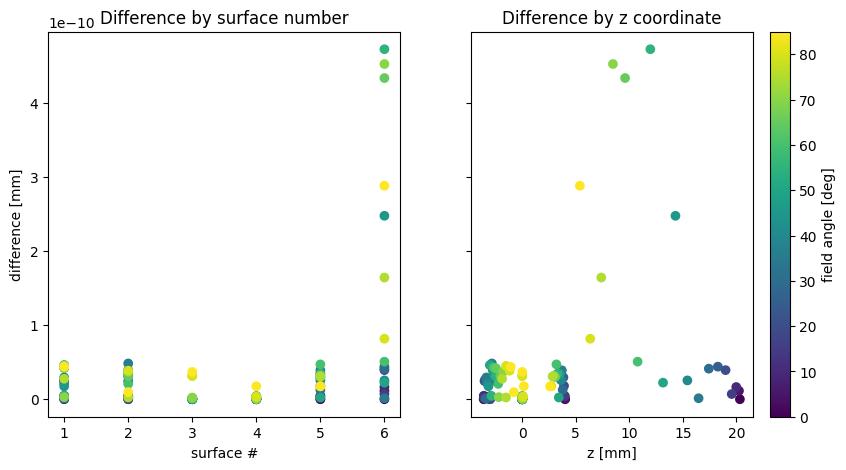

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

_field_coordinates = [f[1] for f in raytrace_comparison.field]
m = ax[0].scatter(raytrace_comparison["index"], raytrace_comparison.distance, c=_field_coordinates)

ax[0].set_xlabel("surface #")
ax[0].set_ylabel("difference [mm]")
ax[0].set_title("Difference by surface number")

ax[1].scatter(raytrace_comparison.z_opticstudio, raytrace_comparison.distance, c=_field_coordinates)

ax[1].set_xlabel("z [mm]")
ax[1].set_title("Difference by z coordinate")

plt.colorbar(m, ax=ax[1], label="field angle [deg]")

## Zernike standard coefficients

Calculate the Zernike standard coefficients for the Navarro eye model at different field angles.
Note that the y-axes in the plots are logarithmic.

In [11]:
zernike_central_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_central_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

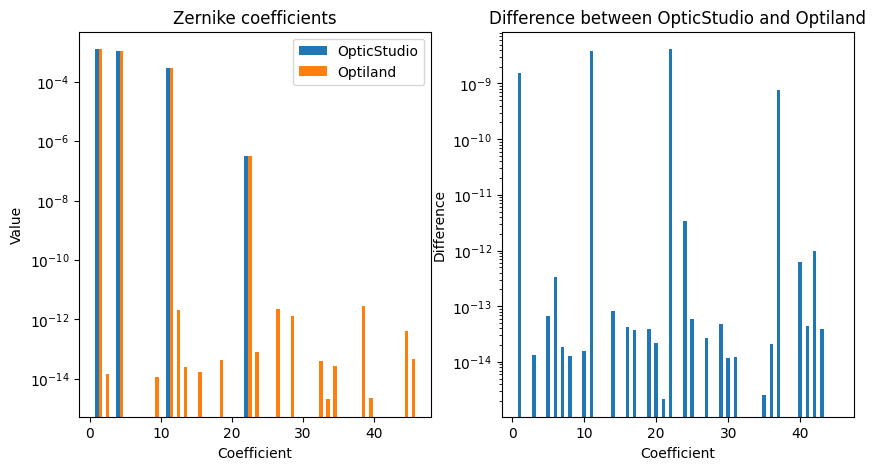

In [12]:
def compare_zernike_coefficients(
    zernike_coefficients_opticstudio: dict,
    zernike_coefficients_optiland: dict,
):
    """
    Compare Zernike coefficients from OpticStudio and Optiland.
    """
    differences = {k: (v - zernike_coefficients_optiland[k]) for k, v in zernike_coefficients_opticstudio.items()}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].bar(
        zernike_coefficients_opticstudio.keys(),
        zernike_coefficients_opticstudio.values(),
        width=0.5,
        label="OpticStudio",
    )
    ax[0].bar(
        np.fromiter(zernike_coefficients_optiland.keys(), dtype=int) + 0.5,
        zernike_coefficients_optiland.values(),
        width=0.5,
        label="Optiland",
    )

    ax[0].set_yscale("log")

    ax[0].set_title("Zernike coefficients")
    ax[0].set_xlabel("Coefficient")
    ax[0].set_ylabel("Value")
    ax[0].legend()

    ax[1].bar(differences.keys(), differences.values(), width=0.5, label="Difference")
    ax[1].axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax[1].set_title("Difference between OpticStudio and Optiland")

    ax[1].set_yscale("log")

    ax[1].set_xlabel("Coefficient")
    ax[1].set_ylabel("Difference")


compare_zernike_coefficients(zernike_central_opticstudio, zernike_central_optiland)

This is an emmetropic eye, so the aberrations are very small. They will be slightly larger at a nonzero eccentricity:

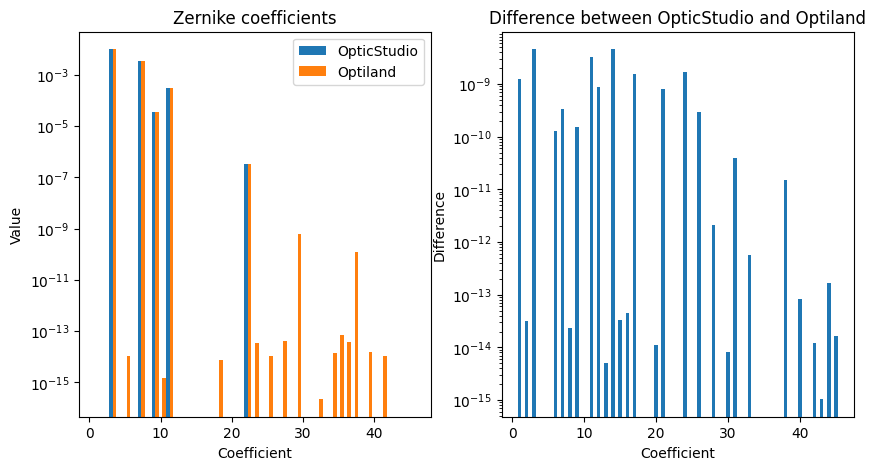

In [15]:
zernike_10deg_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 10),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_10deg_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 10),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_10deg_opticstudio, zernike_10deg_optiland)

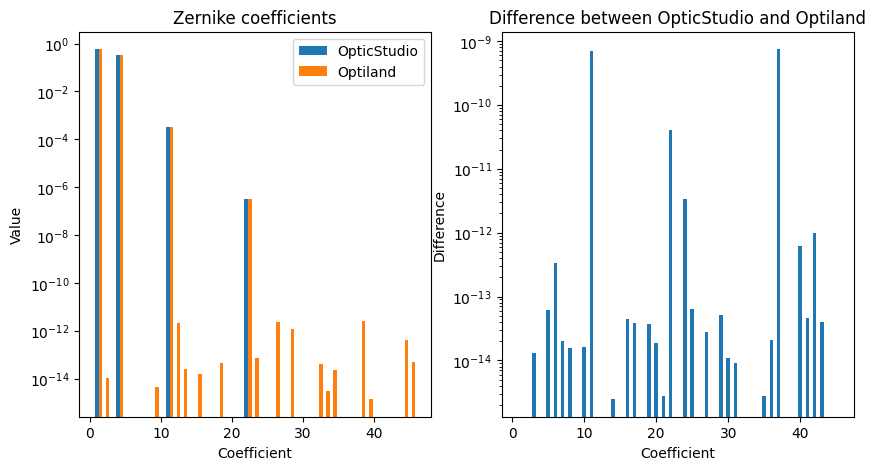

In [16]:
zernike_myopic_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model_myopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_myopic_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model_myopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_myopic_opticstudio, zernike_myopic_optiland)

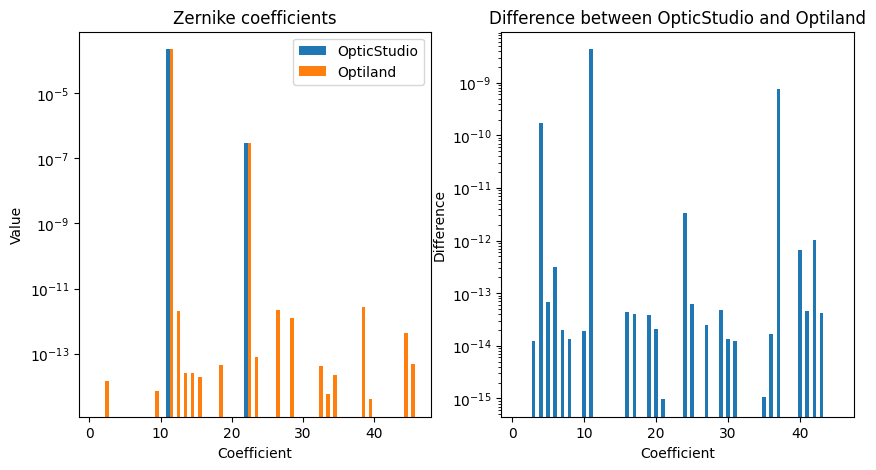

In [17]:
zernike_hyperopic_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model_hyperopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_hyperopic_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model_hyperopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_hyperopic_opticstudio, zernike_hyperopic_optiland)

## RMS-HOA

Calculate the root-mean-square of the higher-order aberrations (RMS-HOA) for the Navarro eye model on the previously defined eye models.

In [32]:
rms_hoa_parameters = {
    "emmetropic": {
        "model": model,
        "field": (0, 0),
    },
    "myopic": {
        "model": model_myopic,
        "field": (0, 0),
    },
    "myopic_10deg": {
        "model": model_myopic,
        "field": (0, 10),
    },
    "hyperopic": {
        "model": model_hyperopic,
        "field": (0, 0),
    },
}

rms_hoa_comparison = []

for name, parameters in rms_hoa_parameters.items():
    rms_hoa_opticstudio = visisipy.analysis.rms_hoa(
        model=parameters["model"],
        field_coordinate=parameters["field"],
        wavelength=0.543,
        sampling=128,
        maximum_term=45,
        field_type="angle",
        backend=OpticStudioBackend,
    )

    rms_hoa_optiland = visisipy.analysis.rms_hoa(
        model=parameters["model"],
        field_coordinate=parameters["field"],
        wavelength=0.543,
        sampling=128,
        maximum_term=45,
        field_type="angle",
        backend=OptilandBackend,
    )

    rms_hoa_comparison.append({
        "name": name,
        "opticstudio": rms_hoa_opticstudio,
        "optiland": rms_hoa_optiland,
        "difference": rms_hoa_opticstudio - rms_hoa_optiland,
    })

pd.DataFrame(rms_hoa_comparison).set_index("name")

,opticstudio,optiland,difference
name,,,
emmetropic,0.000277,0.000277,3.872618e-09
myopic,0.000321,0.000321,6.944495e-10
myopic_10deg,0.003829,0.003829,6.339172e-09
hyperopic,0.000225,0.000225,4.331317e-09


## Refraction

Calculate the on-axis and off-axis refraction using both backends.

In [21]:
refraction_onaxis_opticstudio = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_onaxis_optiland = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

In [22]:
def compare_refractions(
    refraction_opticstudio: FourierPowerVectorRefraction,
    refraction_optiland: FourierPowerVectorRefraction,
):
    """
    Compare refractions from OpticStudio and Optiland.
    """
    df = pd.DataFrame({
        "OpticStudio": asdict(refraction_opticstudio),
        "Optiland": asdict(refraction_optiland),
    })
    df["Difference"] = df["OpticStudio"] - df["Optiland"]

    return df


compare_refractions(refraction_onaxis_opticstudio, refraction_onaxis_optiland)

,OpticStudio,Optiland,Difference
M,0.000044,4.441619e-05,-1.621448e-07
J0,0.000000,1.096728e-09,-1.096728e-09
J45,0.000000,-6.536537e-12,6.536537e-12


In [23]:
refraction_offaxis_opticstudio = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 10),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_offaxis_optiland = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 10),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

compare_refractions(refraction_offaxis_opticstudio, refraction_offaxis_optiland)

,OpticStudio,Optiland,Difference
M,0.09206,9.205908e-02,8.114722e-07
J0,0.11967,1.196703e-01,-1.519318e-07
J45,0.00000,-9.368959e-13,9.368959e-13


In [24]:
refraction_myopic_opticstudio = visisipy.analysis.refraction(
    model=model_myopic,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_myopic_optiland = visisipy.analysis.refraction(
    model=model_myopic,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

compare_refractions(refraction_myopic_opticstudio, refraction_myopic_optiland)

,OpticStudio,Optiland,Difference
M,-5.944698,-5.944699e+00,2.966873e-07
J0,0.000000,1.089957e-09,-1.089957e-09
J45,0.000000,-6.611320e-12,6.611320e-12
